# Clustering

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

In [58]:
df = pd.read_csv("encoded_dataset.csv")
print("Initial data shape:", df.shape)

Initial data shape: (1251, 60)


In [60]:
df.head()

,Age,self_employed,family_history,treatment,remote_work,tech_company,obs_consequence,benefits_binary,Gender_Female,Gender_Male,...,mental_vs_physical_Yes,Country_grouped_Australia,Country_grouped_Canada,Country_grouped_France,Country_grouped_Germany,Country_grouped_Ireland,Country_grouped_Netherlands,Country_grouped_Other,Country_grouped_United Kingdom,Country_grouped_United States
0,37,0,0,1,0,1,0,1,True,False,...,True,False,False,False,False,False,False,False,False,True
1,44,0,0,0,0,0,0,0,False,True,...,False,False,False,False,False,False,False,False,False,True
2,32,0,0,0,0,1,0,0,False,True,...,False,False,True,False,False,False,False,False,False,False
3,31,0,1,1,0,1,1,0,False,True,...,False,False,False,False,False,False,False,False,True,False
4,31,0,0,0,1,1,0,1,False,True,...,False,False,False,False,False,False,False,False,False,True


In [62]:
df = df.astype(int)


In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Age"] = scaler.fit_transform(df[["Age"]])


To retain 80% of the variance, you need 21 principal components.
To retain 90% of the variance, you need 29 principal components.


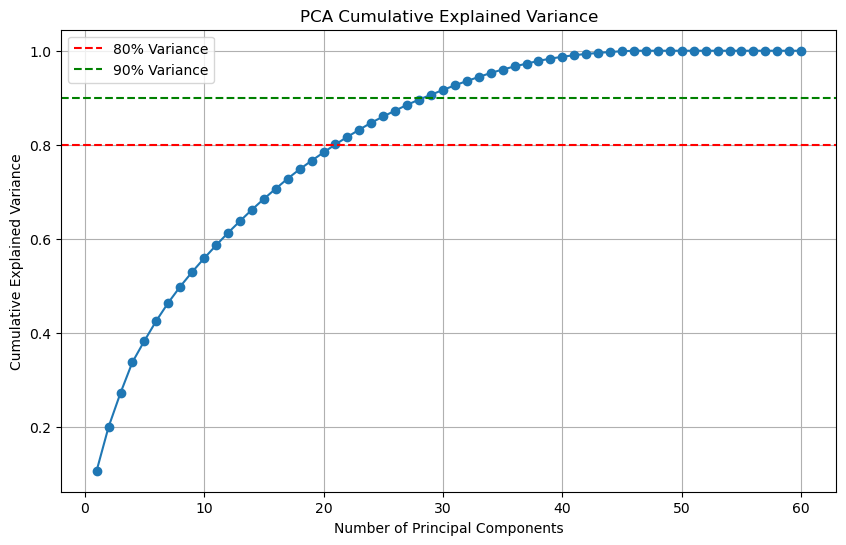

In [66]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


pca = PCA()
pca.fit(df)  


explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)


thresholds = [0.80, 0.90]  

for t in thresholds:
    n_components = np.argmax(cumulative_variance >= t) + 1
    print(f"To retain {t*100:.0f}% of the variance, you need {n_components} principal components.")


plt.figure(figsize=(10,6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
pca_final = PCA(n_components=29)
df_pca = pca_final.fit_transform(df)

In [31]:
!pip install hdbscan


   ---------------------------------------- 0.0/726.2 kB ? eta -:--:--
   ---------------------------------------- 726.2/726.2 kB 3.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Clustering

Mutiple clustering techniques are applied, including KMeans, GMM, Agglomerative Clustering, Spectral Clustering, and HDBSCAN.

For KMeans, GMM, Agglomerative, and Spectral Clustering, where a predefined number of clusters (k) is needed, silhouette scores are calculated for different k values (from 2 to 6), and a line chart is created to visualise the results.

For HDBSCAN, which automatically determines the number of clusters, the silhouette score is calculated based on non-noise points.

All results are stored in a silhouette_scores dictionary for easy comparison across methods.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import hdbscan

In [70]:
# Try different k values: From 2-6
cluster_range = range(2, 7)
silhouette_scores = {
    "K-Means": [],
    "GMM": [],
    "Agglomerative": [],
    "Spectral": [],
    "HDBSCAN": [] 
}

# Try K-Means、GMM、Agglomerative、Spectral Clustering
for k in cluster_range:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_clusters = kmeans.fit_predict(df_pca)
    kmeans_score = silhouette_score(df_pca, kmeans_clusters)
    silhouette_scores["K-Means"].append(kmeans_score)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_clusters = gmm.fit_predict(df_pca)
    gmm_score = silhouette_score(df_pca, gmm_clusters)
    silhouette_scores["GMM"].append(gmm_score)

    # Agglomerative
    agglo = AgglomerativeClustering(n_clusters=k)
    agglo_clusters = agglo.fit_predict(df_pca)
    agglo_score = silhouette_score(df_pca, agglo_clusters)
    silhouette_scores["Agglomerative"].append(agglo_score)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, random_state=42)
    spectral_clusters = spectral.fit_predict(df_pca)
    spectral_score = silhouette_score(df_pca, spectral_clusters)
    silhouette_scores["Spectral"].append(spectral_score)

# HDBSCAN 
hdb = hdbscan.HDBSCAN(min_cluster_size=10) 
hdb_clusters = hdb.fit_predict(df_pca)


mask = hdb_clusters != -1
if mask.sum() > 1: 
    hdb_score = silhouette_score(df_pca[mask], hdb_clusters[mask])
    silhouette_scores["HDBSCAN"].append(hdb_score)
else:
    silhouette_scores["HDBSCAN"].append(np.nan)






D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
D:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

In [72]:
best_scores = {
    "Best K-Means": max(silhouette_scores["K-Means"]),
    "Best GMM": max(silhouette_scores["GMM"]),
    "Best Agglomerative": max(silhouette_scores["Agglomerative"]),
    "Best Spectral": max(silhouette_scores["Spectral"]),
    "Best HDBSCAN": silhouette_scores["HDBSCAN"][0] 
}

print("Best Silhouette Scores for Each Model:")
for model_name, score in best_scores.items():
    print(f"{model_name}: {score:.4f}")

Best Silhouette Scores for Each Model:
Best K-Means: 0.0771
Best GMM: 0.0528
Best Agglomerative: 0.0580
Best Spectral: 0.0097
Best HDBSCAN: 0.1868


## Best Silhouette Scores Summary
After testing multiple clustering methods, **HDBSCAN** achieved the highest silhouette score, indicating better clustering performance compared to the other methods tested.


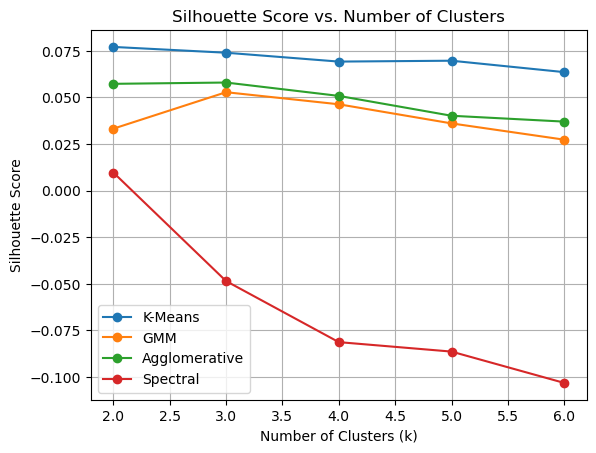

In [74]:
# Plot Line Chart to visualize the results at each k
algorithms = ["K-Means", "GMM", "Agglomerative", "Spectral"]
for algo in algorithms:
    plt.plot(cluster_range, silhouette_scores[algo], marker='o', label=algo)

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.grid(True)
plt.show()

## Silhouette Score vs. Number of Clusters

The line chart below visualises the silhouette scores for different clustering algorithms as the number of clusters (k) increases from 2 to 6.

- **K-Means** shows relatively stable performance across different k values, consistently achieving the highest silhouette scores among the compared methods, although the scores are still low overall (maximum around 0.0771).
- **GMM** and **Agglomerative Clustering** also maintain relatively stable trends, but their silhouette scores are slightly lower compared to K-Means.
- **Spectral Clustering** performs poorly in this case, with silhouette scores dropping sharply as k increases, reaching negative values at k > 2. This suggests that Spectral Clustering may not be suitable for this dataset.
- Overall, none of the traditional clustering methods achieved very high silhouette scores, indicating that the data may not have very well-separated clusters under these algorithms.
- In contrast, **HDBSCAN** (not shown in this line chart because it does not use a fixed k) achieved a much higher silhouette score (0.1868) compared to the others, suggesting that it may be a better fit for the dataset.

This visual comparison highlights that while K-Means performs slightly better among traditional k-based clustering methods, density-based methods like HDBSCAN may be more appropriate for this particular dataset.


## HDBSCAN

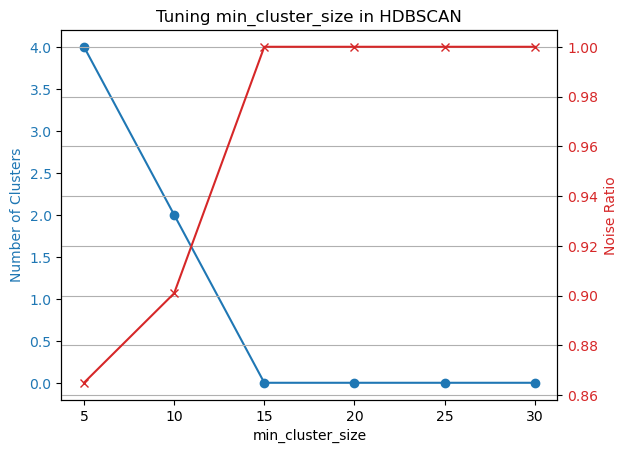

In [77]:
import hdbscan
import matplotlib.pyplot as plt

min_cluster_sizes = range(5, 31, 5)  # try5, 10, 15, 20, 25, 30
cluster_counts = []
noise_ratios = []

for size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size)
    labels = clusterer.fit_predict(df_pca)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = (labels == -1).sum() / len(labels)
    
    cluster_counts.append(n_clusters)
    noise_ratios.append(noise_ratio)

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('min_cluster_size')
ax1.set_ylabel('Number of Clusters', color=color)
ax1.plot(min_cluster_sizes, cluster_counts, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Noise Ratio', color=color)
ax2.plot(min_cluster_sizes, noise_ratios, color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Tuning min_cluster_size in HDBSCAN')
plt.grid(True)
plt.show()


## Analysis of Tuning `min_cluster_size` in HDBSCAN

The tuning plot shows two key metrics as `min_cluster_size` increases:
- **Blue line**: Number of Clusters
- **Red line**: Noise Ratio (proportion of points classified as noise)

## Key observations:

- When `min_cluster_size` is small (e.g., 5), **4 clusters** are detected with a **lower noise ratio** (~86%).
- As `min_cluster_size` increases to 10, the number of clusters drops to **2 clusters**, and the noise ratio slightly increases.
- At `min_cluster_size = 15` and above, **no meaningful clusters** are found anymore — the number of clusters drops to **zero**, and the **noise ratio reaches nearly 100%**.
- From `min_cluster_size = 15` to `30`, the noise ratio stays very high (~100%), suggesting that most points are considered noise.

## Conclusion:

- A very small `min_cluster_size` produces more clusters but risks including noise as small groups.
- A larger `min_cluster_size` leads to overly strict clustering, treating almost all data points as noise.
- Therefore, based on this test, **using a `min_cluster_size` between 5 and 10 may be more appropriate** for this dataset, balancing between cluster detection and avoiding excessive noise.
- Proceed with `min_cluster_size = 10` for the final HDBSCAN clustering.


In [79]:
import hdbscan

hdbscan_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean'
)

hdbscan_labels = hdbscan_clusterer.fit_predict(df_pca)

print(f"Cluster labels (first 10): {hdbscan_labels[:10]}")
print(f"Number of clusters (excluding noise): {len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)}")


Cluster labels (first 10): [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
Number of clusters (excluding noise): 2


In [81]:

labels_series = pd.Series(hdbscan_labels)
print(labels_series.value_counts())


-1    1127
 1     112
 0      12
Name: count, dtype: int64


### Key Observations
- A large majority of the data (over 90%) is classified as **noise** by HDBSCAN.
- Only **two meaningful clusters** are identified, and the cluster sizes are very imbalanced:
  - One small cluster of **112 points**.
  - Another very small cluster of **12 points**.
- This suggests that most of the dataset does not form strong, dense clusters under the current settings.
- The two detected clusters are relatively small compared to the entire dataset size, indicating that the overall structure of the data may be sparse or highly dispersed.

### Interpretation
- HDBSCAN is conservative in assigning cluster labels — only dense and well-separated groups are labelled as clusters.
- The high proportion of noise indicates that **most samples do not strongly belong to any group** based on the current PCA-transformed space and clustering parameters.


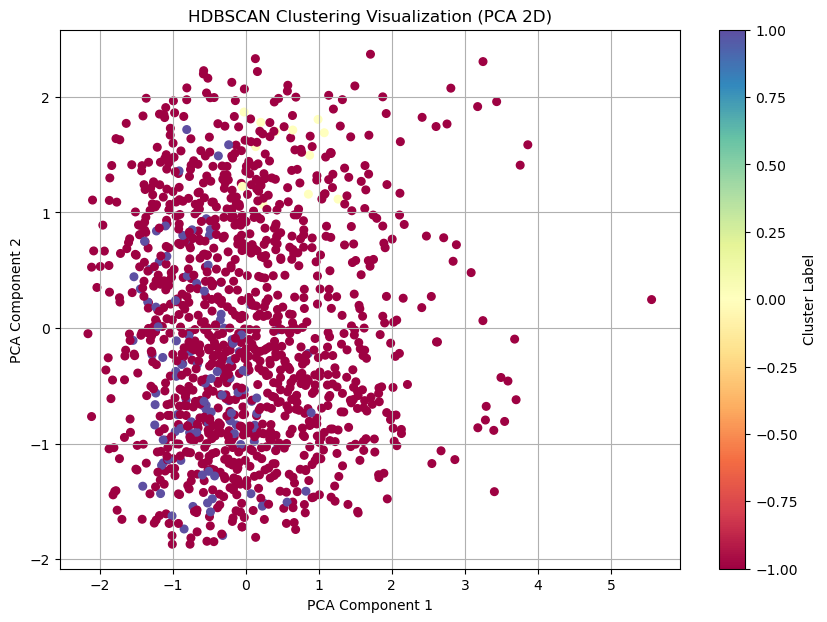

In [83]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
df_2d = pca.fit_transform(df_pca)

plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_2d[:, 0], df_2d[:, 1], c=hdbscan_labels, cmap='Spectral', s=30)
plt.title('HDBSCAN Clustering Visualization (PCA 2D)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.grid(True)
plt.show()


In [85]:
num_noise = (hdbscan_labels == -1).sum()
noise_ratio = num_noise / len(hdbscan_labels)

print(f"Number of noise points: {num_noise}")
print(f"Noise ratio: {noise_ratio:.2%}")


Number of noise points: 1127
Noise ratio: 90.09%


## HDBSCAN Clustering: Final Observations

Based on the clustering results, noise ratio analysis, and 2D PCA visualisation:

### Key Findings

- **High Noise Ratio**: 
  - Out of all samples, about **90% (1127 points)** were classified as noise by HDBSCAN.
  - Only **two small clusters** were identified, containing **112** and **12** samples respectively.
  
- **PCA 2D Visualisation**:
  - The scatter plot shows that the data points are **widely and loosely spread** across the PCA space.
  - There is no obvious dense grouping or separation between regions, which explains why HDBSCAN labelled most points as noise.
  - A few small areas show slightly higher density, corresponding to the two small clusters detected.

- **Interpretation**:
  - The dataset appears to **lack clear, dense cluster structures** after PCA transformation.
  - HDBSCAN, being a density-based algorithm, is **sensitive to the spread and density** of data. 
  - Since the points are broadly distributed with no tight clusters, HDBSCAN identifies very few groups and treats most points as noise.

- **Implications**:
  - In this case, traditional clustering methods (KMeans, GMM, etc.) already showed low silhouette scores, indicating weak cluster structures.
  - The HDBSCAN results further confirm that **this dataset may not have strong natural clusters** in the current feature space.



## Why Strong Clusters Are Difficult to Form in This Dataset

### 1. Data Characteristics

- The original dataset mainly consists of **survey responses**, with features like:
  - Demographics (Age, Gender, Country)
  - Workplace environment (Remote work, Tech company, Benefits, Supervisor support)
  - Mental health perceptions and history (Treatment, Family history, Work interference)
- Most features are **categorical** in nature (e.g., Yes/No/Maybe, or small groups).
- After encoding, the dataset became a large set of **binary (0/1)** columns, without any continuous or strongly varying numerical features (except Age).

### 2. High Sparsity and Low Variance

- In the encoded dataset:
  - Many columns are **one-hot encoded** categories.
  - Most binary features are highly **imbalanced** (e.g., >80% of entries are 0 for some columns).
  - **Sparse data**: very few 1’s compared to 0’s, and the 1’s are scattered across different dimensions.

This leads to a situation where **most data points are not very different from each other**, but the differences that do exist are **small and scattered across many unrelated features**.

### 3. Overlapping Distributions

- In the PCA 2D projection:
  - The data points are **widely and loosely scattered**.
  - There are no tight, well-separated groups.
  - Even if small local "clumps" exist, they are not dense enough compared to the overall spread.

Thus, clustering algorithms like KMeans (which assumes spherical, evenly sized clusters) or density-based methods like HDBSCAN (which looks for dense regions) **struggle to find strong natural separations**.

### 4. Semantic Complexity but Geometric Weakness

- Although the survey captures rich **semantic** information (mental health, work policies, attitudes), after encoding, the information becomes **geometrically weak**.
- Categorical answers like "Yes", "No", "Maybe" are flattened into separate binary flags, losing the subtle relationships between them.
- As a result, **the "distance" between points in feature space becomes noisy and meaningless for clustering**.

---

### Final Conclusion

- The low silhouette scores and high noise ratio are **expected outcomes** for this type of sparse, high-dimensional, mostly binary-encoded survey data.
- To find better structures, future work could explore:
  - Using **alternative embeddings** like UMAP or t-SNE to better preserve local similarities.
  - Reducing dimensionality more aggressively (e.g., feature selection, grouping related questions).
  - Re-framing the analysis task (e.g., predicting treatment instead of unsupervised clustering).



## Agglomerative Clustering


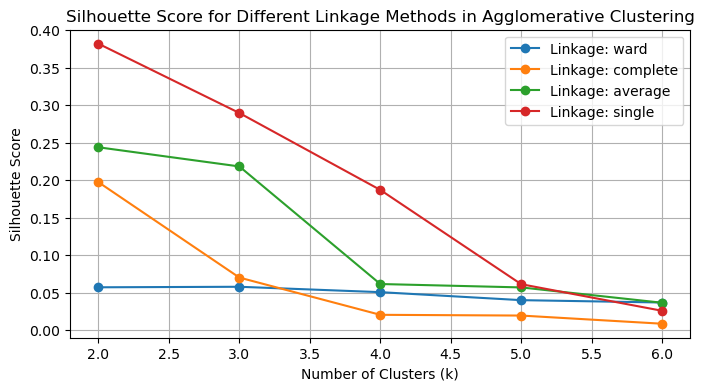

In [88]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=29) 
df_pca = pca.fit_transform(df)

# Try Different Linkage Methods
linkage_methods = ["ward", "complete", "average", "single"]

# k range
cluster_range = range(2, 7)

# Prepare silhouette score dictionary
silhouette_scores = {method: [] for method in linkage_methods}

# Loop over linkage methods and k values
for method in linkage_methods:
    for k in cluster_range:
        
        agglo = AgglomerativeClustering(n_clusters=k, linkage=method)
        clusters = agglo.fit_predict(df_pca)
        score = silhouette_score(df_pca, clusters)
        silhouette_scores[method].append(score)

# Plot Silhouette Score for Different Linkage Methods
plt.figure(figsize=(8, 4))
for method in linkage_methods:
    plt.plot(cluster_range, silhouette_scores[method], marker='o', linestyle='-', label=f"Linkage: {method}")

plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Linkage Methods in Agglomerative Clustering")
plt.legend()
plt.grid()
plt.show()


## Agglomerative Clustering Result Summary

### 1. Method and Preprocessing
- The dataset was first encoded into numerical format.
- Principal Component Analysis (PCA) was applied to reduce dimensionality, preserving 29 components which collectively explain approximately 90% of the variance.
- Agglomerative Clustering was tested using four different linkage methods: `ward`, `complete`, `average`, and `single`.

### 2. Silhouette Score Comparison
- Silhouette scores were calculated for each linkage method across cluster numbers (k) ranging from 2 to 6.
- Results indicated:
  - **Single linkage** achieved the highest silhouette score (~0.39) when `k=2`.
  - **Average linkage** also achieved reasonable scores around `k=2` and `k=3`.
  - **Ward** and **complete** linkages performed relatively poorly in terms of silhouette score on this dataset.

### 3. Final Model Selection
- Based on the silhouette score analysis, **single linkage with 2 clusters** was selected as the final model for further analysis.
- This choice balances clustering quality with simplicity, avoiding over-segmentation or under-clustering.

### 4. Next Steps
- Apply the selected `AgglomerativeClustering` model (`single linkage`, `n_clusters=2`) to the PCA-transformed dataset.
- Visualize the clustering results using a 2D PCA projection.
- Summarize the distribution of samples across clusters and evaluate the final silhouette score.


##  single linkage and setting k = 2 clusters

In [91]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [93]:

# === Step 1: Build final model ===
agglo_final = AgglomerativeClustering(n_clusters=2, linkage='single')
final_labels = agglo_final.fit_predict(df_pca)

# === Step 2: Quick check cluster distribution ===
label_series = pd.Series(final_labels)
cluster_counts = label_series.value_counts().sort_index()
total_samples = len(final_labels)

# Build a summary table
summary_table = pd.DataFrame({
    "Cluster Label": cluster_counts.index,
    "Number of Samples": cluster_counts.values,
    "Percentage": cluster_counts.values / total_samples * 100
})

print(summary_table)




   Cluster Label  Number of Samples  Percentage
0              0               1250   99.920064
1              1                  1    0.079936


In [95]:
# === Step 3: Final Silhouette Score ===
final_silhouette = silhouette_score(df_pca, final_labels)
print(f"Final Silhouette Score: {final_silhouette:.4f}")



Final Silhouette Score: 0.3817


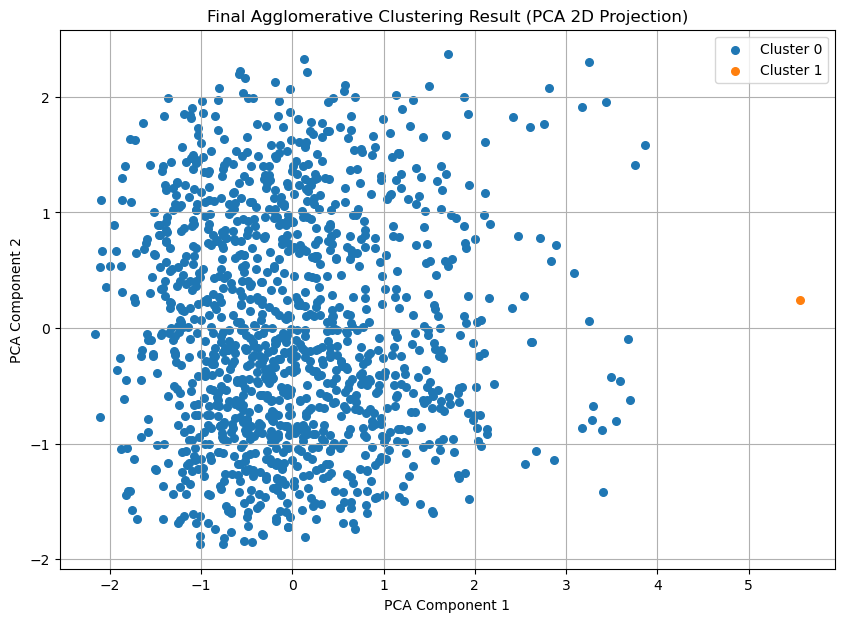

In [97]:
# === Step 4: PCA to 2D for visualization ===
pca_2d = PCA(n_components=2)
df_pca_2d = pca_2d.fit_transform(df)

# === Step 5: Plot clustering result ===
plt.figure(figsize=(10,7))

# Define color map manually
colors = ['red', 'blue']  # Assuming 2 clusters
for label in np.unique(final_labels):
    plt.scatter(df_pca_2d[final_labels==label, 0], 
                df_pca_2d[final_labels==label, 1], 
                label=f"Cluster {label}",
                s=30)

plt.title("Final Agglomerative Clustering Result (PCA 2D Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.legend()
plt.show()

## Current Clustering Outcome Interpretation

The final Agglomerative Clustering result, using **single linkage** and setting **k = 2 clusters**, leads to the following observations:

### Key Findings
- **Cluster Distribution**:
  - **99.92%** of the samples are grouped into a single large cluster.
  - Only **one sample** is assigned to a separate second cluster.
- **Silhouette Score**:
  - The overall silhouette score is **relatively high (0.3817)**.
  - However, this high score is **artificially inflated** by the extreme separation of the single isolated point from the dense main cluster.
- **Visual Inspection**:
  - The PCA 2D projection clearly shows that the dataset forms a **loosely dense cloud**, with one **outlier** far away.
  - There is no meaningful separation into two balanced or interpretable groups.

### Interpretation
- Although the silhouette score suggests good separation, **the clustering is highly imbalanced and not practically useful**.
- Single linkage is known to be sensitive to outliers (chaining effect), and here it incorrectly treats an outlier as a separate cluster rather than uncovering meaningful subgroups within the data.

### Recommendation
- It is advised to explore clustering with **average linkage** and **k = 2 or 3**.
- Average linkage tends to be more robust against chaining effects and may produce **more balanced and interpretable clusters**.




##  Average linkage and k = 2 

In [100]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


#  Build final model with average linkage
agglo_avg = AgglomerativeClustering(n_clusters=2, linkage='average')
final_labels_avg = agglo_avg.fit_predict(df_pca)

#  Cluster distribution
label_series_avg = pd.Series(final_labels_avg)
cluster_counts_avg = label_series_avg.value_counts().sort_index()
total_samples_avg = len(final_labels_avg)

# Build a summary table
summary_table_avg = pd.DataFrame({
    "Cluster Label": cluster_counts_avg.index,
    "Number of Samples": cluster_counts_avg.values,
    "Percentage": cluster_counts_avg.values / total_samples_avg * 100
})

print("=== Cluster Distribution Summary ===")
print(summary_table_avg)



=== Cluster Distribution Summary ===
   Cluster Label  Number of Samples  Percentage
0              0                 11    0.879297
1              1               1240   99.120703


In [102]:
#Final Silhouette Score
final_silhouette_avg = silhouette_score(df_pca, final_labels_avg)
print(f"\nFinal Silhouette Score (Average Linkage, k=2): {final_silhouette_avg:.4f}")



Final Silhouette Score (Average Linkage, k=2): 0.2438


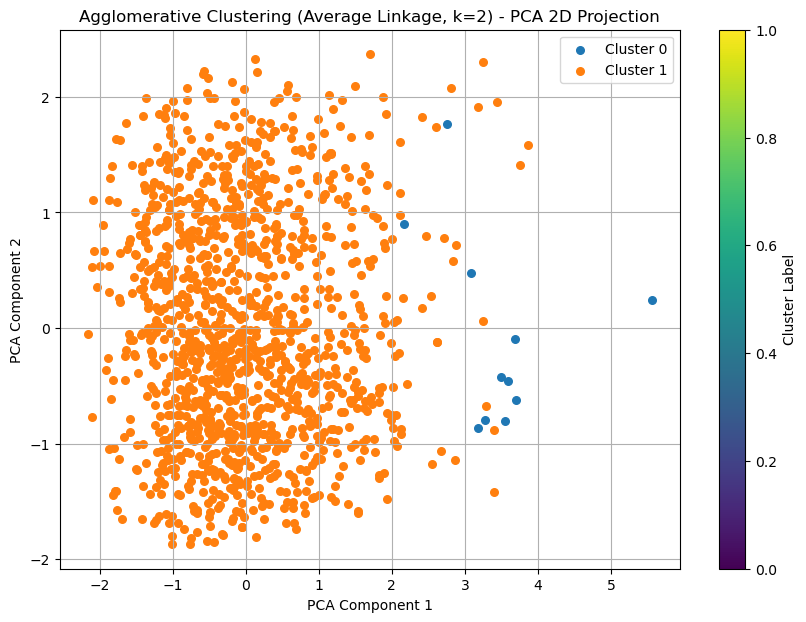

In [104]:
pca_2d_avg = PCA(n_components=2)
df_pca_2d_avg = pca_2d_avg.fit_transform(df)


plt.figure(figsize=(10,7))

colors = ['red', 'blue'] 
for label in np.unique(final_labels_avg):
    plt.scatter(df_pca_2d_avg[final_labels_avg==label, 0],
                df_pca_2d_avg[final_labels_avg==label, 1],
                label=f"Cluster {label}",
                s=30)

plt.title("Agglomerative Clustering (Average Linkage, k=2) - PCA 2D Projection")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.colorbar(label="Cluster Label")
plt.show()


## Agglomerative Clustering Using Average Linkage (k=2)

### 1. Methodology
- The dataset was first processed through Principal Component Analysis (PCA), reducing the dimensionality to 29 components while retaining approximately 90% of the original variance.
- Agglomerative Clustering was applied with the `average` linkage method and `k=2` clusters.

### 2. Clustering Results
- **Cluster 0** contains 11 samples (approximately 0.88% of the dataset).
- **Cluster 1** contains 1240 samples (approximately 99.12% of the dataset).
- The final silhouette score is **0.2438**, indicating moderate clustering quality.

### 3. Visualisation
- A 2D PCA projection was used to visualise the clustering result.
- The majority of the samples form a single dense cluster, while a small group of samples is separated, suggesting minor but meaningful differences in feature space.

### 4. Interpretation
- The dataset primarily consists of a large homogeneous group.
- A small set of samples exhibits sufficient feature divergence to be distinguished as a separate cluster.
- Compared to the previous single linkage result (which isolated only one sample), average linkage provides a more balanced and interpretable clustering outcome.




### Comparison with Single Linkage (Previous Result)

| Aspect | Single Linkage (k=2) | Average Linkage (k=2) |
|:------|:---------------------|:---------------------|
| Small Cluster Size | 1 sample | 11 samples |
| Large Cluster Size | 1250 samples | 1240 samples |
| Silhouette Score | 0.3817 | 0.2438 |
| Visual Separation | Very clear (isolated outlier) | Slightly more balanced but still weak separation |
| Practical Meaningfulness | Very poor (single outlier) | Slightly better but still not ideal |

### Key Insights

- **Single linkage** produced an artificially high silhouette score by isolating a single outlier far away from the main data cloud.
- **Average linkage** results in a slightly more balanced clustering (11 vs 1240), although the separation is still weak.
- The silhouette score for average linkage is lower (0.2438), but it reflects a **more realistic** and **less outlier-driven** separation than single linkage.
- However, the majority of points are still grouped into one cluster, confirming that **strong natural clusters do not exist** in this dataset under the current PCA space.

### Conclusion

- Switching to average linkage slightly improves the **interpretability** of the clustering outcome compared to single linkage.
- Nonetheless, both methods confirm that **the dataset lacks strong intrinsic clustering structure** based on the current preprocessing and feature space.




In [107]:
df_with_labels = df.copy()
df_with_labels['cluster'] = final_labels_avg


cluster_profiles = df_with_labels.groupby('cluster').mean()


pd.set_option('display.max_columns', None) 
print("=== Cluster Feature Averages ===")
display(cluster_profiles)


=== Cluster Feature Averages ===


,Age,self_employed,family_history,treatment,remote_work,tech_company,obs_consequence,benefits_binary,Gender_Female,Gender_Male,Gender_Other,work_interfere_Never,work_interfere_Not applicable,work_interfere_Often,work_interfere_Rarely,work_interfere_Sometimes,care_options_No,care_options_Not sure,care_options_Yes,wellness_program_Don't know,wellness_program_No,wellness_program_Yes,seek_help_Don't know,seek_help_No,seek_help_Yes,leave_Don't know,leave_Somewhat difficult,leave_Somewhat easy,leave_Very difficult,leave_Very easy,mental_health_consequence_Maybe,mental_health_consequence_No,mental_health_consequence_Yes,phys_health_consequence_Maybe,phys_health_consequence_No,phys_health_consequence_Yes,coworkers_No,coworkers_Some of them,coworkers_Yes,supervisor_No,supervisor_Some of them,supervisor_Yes,mental_health_interview_Maybe,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_Maybe,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_Don't know,mental_vs_physical_No,mental_vs_physical_Yes,Country_grouped_Australia,Country_grouped_Canada,Country_grouped_France,Country_grouped_Germany,Country_grouped_Ireland,Country_grouped_Netherlands,Country_grouped_Other,Country_grouped_United Kingdom,Country_grouped_United States
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3.670574,0.363636,0.181818,0.727273,0.636364,0.636364,0.454545,0.454545,0.181818,0.818182,0.000000,0.272727,0.090909,0.181818,0.090909,0.363636,0.272727,0.454545,0.272727,0.272727,0.363636,0.363636,0.272727,0.272727,0.454545,0.272727,0.090909,0.272727,0.090909,0.272727,0.454545,0.272727,0.272727,0.727273,0.272727,0.000000,0.363636,0.454545,0.181818,0.454545,0.181818,0.363636,0.090909,0.818182,0.090909,0.636364,0.272727,0.090909,0.636364,0.272727,0.090909,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.090909,0.272727,0.636364
1,-0.032562,0.111290,0.392742,0.503226,0.293548,0.820968,0.141935,0.377419,0.197581,0.785484,0.016935,0.168548,0.210484,0.111290,0.138710,0.370968,0.400000,0.248387,0.351613,0.148387,0.671774,0.179839,0.290323,0.514516,0.195161,0.450000,0.100000,0.211290,0.077419,0.161290,0.379839,0.390323,0.229839,0.213710,0.739516,0.046774,0.204839,0.617742,0.177419,0.310484,0.279839,0.409677,0.166129,0.801613,0.032258,0.441935,0.397581,0.160484,0.457258,0.270161,0.272581,0.016935,0.058065,0.010484,0.03629,0.021774,0.021774,0.092742,0.145968,0.595968


In [109]:

diff = cluster_profiles.loc[0] - cluster_profiles.loc[1]


top_diff_features = diff.abs().sort_values(ascending=False).head(10)

print("=== Top 10 Most Different Features Between Clusters ===")
print(top_diff_features)



=== Top 10 Most Different Features Between Clusters ===
Age                              3.703135
phys_health_consequence_Maybe    0.513563
phys_health_consequence_No       0.466789
remote_work                      0.342815
obs_consequence                  0.312610
wellness_program_No              0.308138
seek_help_Yes                    0.259384
self_employed                    0.252346
seek_help_No                     0.241789
treatment                        0.224047
dtype: float64


## Cluster Profiling and Feature Differences

After clustering the dataset into two groups (using Agglomerative Clustering with Average Linkage, k=2), further analysis was performed to understand the feature distributions across clusters.

### Step 1: Cluster Profiling
- The average values of all features were computed for each cluster.
- This profiling provides insights into the general characteristics of samples belonging to each cluster.

### Step 2: Feature Difference Analysis
- The feature-wise differences between the two clusters were calculated.
- The top 10 features with the largest differences were identified.

### Key Observations
- **Age** is the most distinguishing feature between the two clusters, with an average difference of approximately **3.7 years**.
- **Physical health consequences** (especially the "Maybe" and "No" responses) show significant separation between clusters.
- **Remote work**, **wellness program availability**, **self-employment**, and **seeking help for mental health** also show notable differences.
- These findings suggest that although the clustering is not perfectly balanced, there are meaningful distinctions between the groups based on work environment, health perceptions, and demographics.

### Conclusion
- Even though most samples are concentrated in a single cluster, the feature differences highlight potential **subgroup trends** within the dataset.


## Final Conclusion: Why Clustering Performance is Poor on This Dataset

After multiple clustering attempts (KMeans, GMM, Agglomerative Clustering, HDBSCAN), the results consistently show low silhouette scores, heavy class imbalance, and poor separation.  
This suggests that **the difficulty lies not in the clustering methods themselves, but in the fundamental characteristics of the dataset**.

### 1. Data Characteristics and Encoding Issues
- The original dataset is a **survey-based dataset** with mostly **categorical** features (e.g., demographics, workplace environment, mental health perceptions).
- After encoding, the dataset becomes **high-dimensional and sparse**, dominated by **binary (0/1) variables**.
- Only one meaningful continuous feature (Age) exists; the rest are fragmented across many sparse binary columns.

### 2. High Sparsity and Feature Imbalance
- Many binary features are **highly imbalanced** (e.g., >80% of entries are 0), causing **most points to be similar across irrelevant features**.
- The sparsity leads to a situation where **distances between samples lose meaning**, making it hard for distance-based clustering algorithms to find meaningful groupings.

### 3. Overlapping Distributions and Geometric Weakness
- In the PCA 2D projections, data points are **widely and loosely scattered**, with no clear, dense clusters.
- Even after aggressive dimensionality reduction, there are **no tight local groupings**, only a few scattered outliers.
- Survey semantic richness does not translate into geometric separability: **flattening answers like "Yes", "No", "Maybe" into binary flags removes relational nuance**, further weakening clustering structure.

### 4. Clustering Attempts and Observations
- **Single linkage** isolated only a single outlier as a cluster, artificially boosting silhouette score but offering no meaningful grouping.
- **Average linkage** performed slightly better, separating a small group (11 samples) but still resulting in highly unbalanced clusters and low silhouette (~0.24).
- Across all methods, the clustering outcomes are dominated by one massive cluster and small noisy groups, **confirming the lack of strong natural segmentation**.

### 5. Business Insight Limitations
- Although tentative trends (e.g., age differences, health consequence perceptions, remote work differences) can be extracted between clusters,  
these insights are **weak and statistically fragile**, given the extreme cluster imbalance and low clustering strength.
- Therefore, business interpretation from current clustering must be done **with extreme caution**, if at all.

### 6. Summary: Root Cause of Poor Clustering
> **The primary reason clustering performs poorly is the combination of high-dimensional sparsity, feature imbalance, overlapping distributions, and the semantic–geometric gap introduced by encoding survey data.**



